In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, classification_report


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # RobustScaler uses interquartile range q1 - q3 
                                                                             # MinMaxScaler uses min-max difference

from tqdm import tqdm
    
# ML MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# TF

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow import keras

# For saving models
import pickle


# Helper functions for testing models

In [80]:
def test_classification_model(model, test_df, conf_matrix = False, filename_suffix = ''):
    
    """ 
        Test classification model 
    
        NOTE: last columns must to be label column 'y'
        
    """

    x_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values
    
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_pred,y_test)
    confusion_matr = confusion_matrix(y_pred,y_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {fscore}')
    
    if (conf_matrix):
        print(f'Confusion matrix: \n {confusion_matr}')
    
    #save metrics to file 

    s = [str(round(accuracy, 4)), str(round(precision, 4)), str(round(recall, 4)), str(round(fscore, 4))]

    with open(f'metrics_{filename_suffix}.txt', 'w') as file:
        file.write('\t'.join(s))
    

In [81]:
def test_regression_model(model, test_df, threshold = 0.5, is_keras = False, conf_matrix = False, filename_suffix = ''):
    
    """ We suppose that the model returns result in [0, 1] 
        so we need to have an optimal treshold
        
        NOTE: test_df last column should be target column 'y'
        
    """
    
    x_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values
    
    # For Logistic regression 
    
    if(not is_keras):
        y_prob = model.predict_proba(x_test)[:, 1]
    else:
        y_prob = model.predict(x_test)
    
    
    y_pred = y_prob.copy()
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    accuracy = accuracy_score(y_pred,y_test)
    confusion_matr = confusion_matrix(y_pred,y_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {fscore}')
    print(f'ROC AUC: {roc_auc}')
    
    
    if (conf_matrix):
        print(f'Confusion matrix: \n {confusion_matr}')
    
    #save metrics to file 

    s = [str(round(accuracy, 4)), str(round(precision, 4)), str(round(recall, 4)), str(round(fscore, 4))]

    with open(f'metrics_{filename_suffix}.txt', 'w') as file:
        file.write('\t'.join(s))
    

# Feature engineering

# 2 features functions 

In [210]:
def sum_features(df, feature1_name, feature2_name, suffix = '_sum2'):
    
    """ Add sum of the given features """
    
    feature1_values = df.loc[:, feature1_name]
    feature2_values = df.loc[:, feature2_name]

    new_feature_name = feature1_name + '-' + feature2_name + suffix
    new_feature_values = feature1_values + feature2_values

    df.loc[:, new_feature_name] = new_feature_values

def sub_features(df, feature1_name, feature2_name, suffix = '_sub2'):
    
    """ Add substraction of the given features """
    
    #get features from the dataframe
    feature1_values = df.loc[:, feature1_name]
    feature2_values = df.loc[:, feature2_name]

    # define a new name for the new feature
    new_feature_name = feature1_name + '-' + feature2_name + suffix
    new_feature_name2 = feature2_name + '-' + feature1_name + suffix
    
    # create 
    new_feature_values = feature1_values - feature2_values
    new_feature_values2 = feature2_values - feature1_values
    
    df.loc[:, new_feature_name] = new_feature_values
    df.loc[:, new_feature_name] = new_feature_values2

def abs_features(df, feature1_name, feature2_name, suffix = '_abs2'):
    
    """ Add an absolute difference of the given features """
    
    #get features from the dataframe
    feature1_values = df.loc[:, feature1_name]
    feature2_values = df.loc[:, feature2_name]

    # define a new name for the new feature
    new_feature_name = feature1_name + '-' + feature2_name + suffix
    
    # create 
    new_feature_values = np.abs(feature1_values - feature2_values)

    df.loc[:, new_feature_name] = new_feature_values
    
    
two_features_functions = [sum_features, sub_features, abs_features]

In [211]:
def add_new_features(df):
    
    feature_labels = df.columns[:-1]

    for ind1 in range(len(feature_labels)):
        for ind2 in range(ind1 + 1, len(feature_labels), 1):
            
            #print(ind1, ind2)

            feature1_name = feature_labels[ind1]
            feature2_name = feature_labels[ind2]
        
            for function in two_features_functions:
                function(df, feature1_name, feature2_name)
        

            
    # set 'y' column as the last column
    columns = df.columns.to_list()
    ind = columns.index('y')
    new_columns = columns[:ind] + columns[ind + 1:] + ['y']

    df = df[new_columns]
    
    return df

In [ ]:
train_df = add_new_features(train_df.copy())
test_df = add_new_features(test_df.copy())

# Scale features

In [109]:
scaler = StandardScaler()

train_df.iloc[:, :-1] = scaler.fit_transform(train_df.iloc[:, :-1])
test_df.iloc[:, :-1] = scaler.transform(test_df.iloc[:, :-1])

In [43]:
pickle.dump(scaler, open(f'../models/{class_name}/scaler.pkl', 'wb'))

In [10]:
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

# Simple train 

In [ ]:
train_df = train_df.sample(frac = 1)

features = train_df.iloc[:, :-1].values
labels = train_df.iloc[:, -1].values


#model = LogisticRegression(max_iter = 10000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 1.0)
#model = SVC(C = 6, kernel='rbf')
#model = KNeighborsClassifier(n_neighbors = 35, metric='minkowski', p = 11)
#model = DecisionTreeClassifier(criterion='gini')

model.fit(features, labels)

test_classification_model(model)

# KFold. Train + Validation 

In [ ]:
foldes_number = 10

folds = StratifiedKFold(n_splits = foldes_number)

best_model = None
best_metric = 0

all_metrics = []

metric_name = 'accuracy' # one of: roc_auc, accuracy, precision, recall, fscore

train_df = train_df.sample(frac = 1)

features = train_df.iloc[:, :-1].values
labels = train_df.iloc[:, -1].values

for ind, (train_index, test_index) in enumerate(folds.split(features, labels)):
    
    
    x_train = features[train_index]
    x_test = features[test_index]
    
    y_train = labels[train_index]
    y_test = labels[test_index]
    
    
    #model = LogisticRegression(max_iter = 10000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 1.0)
    #model = SVC(C = 4, kernel='linear')
    model = KNeighborsClassifier(n_neighbors = 1, metric='minkowski', p = 1)
    #model = DecisionTreeClassifier(criterion='gini')
    
    model.fit(x_train, y_train)
    
    #y_prob = model.predict_proba(x_test)[:, 1] #Logistic regression
    
    y_pred = model.predict(x_test)
    
    if (metric_name == 'roc_auc'):
        metric = roc_auc_score(y_test, y_prob)
    elif (metric_name == 'accuracy'):
        metric = accuracy_score(y_pred, y_test)
    elif (metric_name == 'precision' or metric_name == 'recall' or metric_name == 'fscore'):
        
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
        
        if (metric_name == 'precision'):
            metric = precision
        elif (metric_name == 'recall'):
            metric = recall
        elif (metric_name == 'fscore'):
            metric = fscore
        
    all_metrics.append(metric)
    
    
    if (metric > best_metric):
        best_metric = metric
        best_model = model
        
        
    print(f'Fold {ind}. {metric_name}:', metric)
    
    print()
    print('----Test Metrics----')
    test_classification_model(model, test_df)
    print()
    
    

print()
print(f'{metric_name} mean: {np.mean(all_metrics)}')
print(f'{metric_name} std: {np.std(all_metrics)}')
print()

test_classification_model(best_model, test_df)


# GridSearch parameters

In [12]:
# KNN parameters
knn_parameters = {
    'n_neighbors': [i for i in range(1, 100, 1)], # tip: sqrt(number_of_samples)
    'metric': ['minkowski'],
    'p': [i for i in range(1, 5, 1)],
}

#SVC parameters
svc_parameters = {
    'kernel': ['rbf',],
    'C': [i for i in range(1, 10, 1)],
    'degree': [i for i in range(1, 10, 1)],
}

# RANDOM FOREST parameters

random_forest_parameters = {
    'n_estimators': [i for i in range(1, 301, 50)],
    'min_samples_split': [i for i in range(2, 100, 10)],
    'n_jobs': [-1]
}

# LOGISTIC REGRESSION 
logistic_regression_parameters = {
    'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': [i for i in range(1, 10, 1)], 
    'max_iter': [10000],
    #'l1_ratio': [0.2, 0.4, 0.5,0.6, 0.65, 0.7, 0.9]
}


# TRAIN/TEST GRIDSEARCH

In [49]:
from itertools import product


train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

test_features = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

metric_name = 'accuracy'

best_model = None
best_metric = -1

# parameter for the model
parameters = random_forest_parameters

for params in tqdm(list(product(*parameters.values()))):
    
    model_params = dict(zip(parameters.keys(), params))
    
    #model = KNeighborsClassifier(**model_params) 
    #model = SVC(**model_params)
    model = RandomForestClassifier(**model_params)
    #model = LogisticRegression(**model_params)
    
    model.fit(train_features, train_labels)
     
    y_pred = model.predict(test_features)
    
    #Regression 
    
#     y_prob = model.predict_proba(test_features)[:, 1]

#     y_pred = y_prob
#     y_pred[y_pred > 0.5] = 1
#     y_pred[y_pred < 0.5] = 0
    
    if (metric_name == 'roc_auc'):
        metric = roc_auc_score(y_test, y_prob)
    elif (metric_name == 'accuracy'):
        metric = accuracy_score(y_pred, y_test)
    elif (metric_name == 'precision' or metric_name == 'recall' or metric_name == 'fscore'):
        
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
        
        if (metric_name == 'precision'):
            metric = precision
        elif (metric_name == 'recall'):
            metric = recall
        elif (metric_name == 'fscore'):
            metric = fscore
    
    if (metric > best_metric):
        best_metric = metric
        best_model = model
        
    
print(f'Best {metric_name}: {best_metric}')
print()

print('----Test Metrics----')
test_classification_model(best_model, test_df)
#test_regression_model(best_model, test_df, threshold = 0.5)
print()


print('Best model')
print(best_model)

100%|██████████| 60/60 [00:20<00:00,  2.99it/s]

Best accuracy: 0.6927710843373494

----Test Metrics----
Accuracy: 0.6927710843373494
Precision: 0.6875
Recall: 0.6790123456790124
F1-score: 0.6832298136645963

Best model
RandomForestClassifier(n_estimators=151, n_jobs=-1)


In [50]:
#pickle.dump(best_model, open(f'../models/{class_name}/knn_model.pkl', 'wb'))
#pickle.dump(best_model, open(f'../models/{class_name}/svc_model.pkl', 'wb'))
pickle.dump(best_model, open(f'../models/{class_name}/random_forest_model.pkl', 'wb'))
#pickle.dump(best_model, open(f'../models/{class_name}/logistic_regression_model.pkl', 'wb'))

# LGBM

In [101]:
from lightgbm import LGBMClassifier 

train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

best_model = LGBMClassifier(n_estimators = 110, num_leaves = 20).fit(X = train_features, y = train_labels, eval_set = (test_features, test_labels), eval_metric = 'auc', verbose = 0)

pickle.dump(best_model, open(f'../models/{class_name}/lgbm_model.pkl', 'wb'))

test_regression_model(best_model, test_df, is_keras = False, threshold = 0.4)

Accuracy: 0.6506024096385542
Precision: 0.6236559139784946
Recall: 0.7160493827160493
F1-score: 0.6666666666666666
ROC AUC: 0.706318082788671


In [ ]:
feature_values = best_model.feature_importances_
feature_names = train_df.columns[:-1].values

plt.figure(figsize = (5, 5), dpi = 150)
plt.title('Features importance')
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=feature_values, y=feature_names, color="b")


# Keras MLP

In [103]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [110]:
train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

model_checkpoint_callback = ModelCheckpoint(
    filepath=f'./best_model_{class_name}/',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

mlp = Sequential()

mlp.add(Dense(1024, input_shape = (train_features.shape[1], ), activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(1, activation = 'sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(train_features, train_labels, epochs=10, batch_size=4, verbose=1, validation_data = (test_features, test_labels), 
        callbacks=[model_checkpoint_callback, roc_callback(training_data=(train_features, train_labels),validation_data=(test_features, test_labels))])

test_results = mlp.evaluate(test_features, test_labels)

Epoch 1/10
124/124 [==============================] - 1s 5ms/step - loss: 0.7042 - accuracy: 0.5028 - val_loss: 0.6651 - val_accuracy: 0.6506
INFO:tensorflow:Assets written to: ./best_model_cm\assets
roc-auc: 0.7627 - roc-auc_val: 0.6835                                                                                                    
Epoch 2/10
124/124 [==============================] - 0s 3ms/step - loss: 0.5804 - accuracy: 0.7025 - val_loss: 0.6469 - val_accuracy: 0.6205
roc-auc: 0.8122 - roc-auc_val: 0.7182                                                                                                    
Epoch 3/10
124/124 [==============================] - 0s 3ms/step - loss: 0.5644 - accuracy: 0.6874 - val_loss: 0.6611 - val_accuracy: 0.6566
INFO:tensorflow:Assets written to: ./best_model_cm\assets
roc-auc: 0.8301 - roc-auc_val: 0.7098                                                                                                    
Epoch 4/10
124/124 [========================

In [ ]:
mlp.save(f'../models/{class_name}/keras_model')

# KFOLD GRIDSEARCH

In [230]:
#features = train_df.iloc[:, :-1].values
#labels = train_df.iloc[:, -1].values


#model = LogisticRegression()
model = SVC()
#model = KNeighborsClassifier()
#model = DecisionTreeClassifier()

metric_name = 'accuracy'

clf = GridSearchCV(model, svc_parameters n_jobs = -1, scoring = ['accuracy', 'precision', 'recall', 'f1'], refit = metric_name)
clf.fit(features, labels)

search_results = pd.DataFrame(clf.cv_results_)

best_model = clf.best_estimator_

print(f'----Best model----')
print(f'Model: {clf.best_estimator_}')
print(f'Metric ({metric_name}): {clf.best_score_}')
print()

test_classification_model(best_model, test_df)

----Best model----
Model: SVC(C=1)
Metric (accuracy): 0.5981012658227848

Accuracy: 0.7310126582278481
Precision: 0.7413793103448276
Recall: 0.7633136094674556
F1-score: 0.7521865889212829


# Ensemble

In [112]:
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

model1 = pickle.load(open(f'../models/{class_name}/knn_model.pkl', 'rb'))
model2 = pickle.load(open(f'../models/{class_name}/svc_model.pkl', 'rb'))
model3 = pickle.load(open(f'../models/{class_name}/random_forest_model.pkl', 'rb'))
model4 = pickle.load(open(f'../models/{class_name}/lgbm_model.pkl', 'rb'))
model5 = keras.models.load_model(f'../models/{class_name}/keras_model')
model6 = pickle.load(open(f'../models/{class_name}/logistic_regression_model.pkl', 'rb'))

ensemble = {
    'KNN': model1,
    'SVC': model2,
    'RandomForest': model3,
    'LGBM': model4,
    'Keras': model5,
    'LogisticRegression': model6
}

thresholds = {
    'KNN': 0.5,
    'SVC': 0.5,
    'RandomForest': 0.5,
    'LGBM': 0.3,
    'Keras': 0.4,
    'LogisticRegression': 0.42
}

ensemble_type = 'voting'

y_pred = []
y_prob = []


for test_feature in tqdm(test_features):
    
    result = 0
    
    predictions_count = [0, 0]
    predictions = []
    
    for model_type in ensemble:

        model = ensemble[model_type]

        if (model_type == 'Keras'):
            prediction = model.predict(test_feature[None])[0]      
        else:
            prediction = model.predict([test_feature])

        prediction = prediction[0]
        
        predictions.append(prediction)
        
        if (prediction > thresholds[model_type]):
            prediction = 1.0
        else:
            prediction = 0.0
    
        predictions_count[int(prediction)] += 1
    
    
    if (ensemble_type == 'voting'):
        if (predictions_count[1] >= predictions_count[0]):
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    if (ensemble_type == 'mean'):
        
        y_prob.append(np.mean(predictions))

        if (np.mean(predictions) > 0.4):
            y_pred.append(1)
        else:
            y_pred.append(0)

accuracy = accuracy_score(y_pred,test_labels)
confusion_matr = confusion_matrix(y_pred,test_labels)
precision, recall, fscore, support = precision_recall_fscore_support(test_labels, y_pred, average='binary')

print(f'Ensemble type: {ensemble_type}')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {fscore}')
print(f'Confusion matrix: \n {confusion_matr}')

s = [str(round(accuracy, 4)), str(round(precision, 4)), str(round(recall, 4)), str(round(fscore, 4))]

with open('metrics.txt', 'w') as file:
    file.write('\t'.join(s))

    
if (ensemble_type == 'mean'):
    fpr, tpr, tresholds = roc_auc_plot(test_labels, y_prob, print_table = False)

100%|██████████| 88/88 [00:10<00:00,  8.00it/s]

Ensemble type: voting
Accuracy: 0.7386363636363636
Precision: 0.7555555555555555
Recall: 0.7391304347826086
F1-score: 0.7472527472527473
Confusion matrix: 
 [[31 12]
 [11 34]]


# Test metrics. Accuracy, Precision, Recall, F1-score

In [ ]:
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

model1 = pickle.load(open(f'../models/{class_name}/knn_model.pkl', 'rb'))
model2 = pickle.load(open(f'../models/{class_name}/svc_model.pkl', 'rb'))
model3 = pickle.load(open(f'../models/{class_name}/random_forest_model.pkl', 'rb'))
model4 = pickle.load(open(f'../models/{class_name}/lgbm_model.pkl', 'rb'))
model5 = keras.models.load_model(f'../models/{class_name}/keras_model')
model6 = pickle.load(open(f'../models/{class_name}/logistic_regression_model.pkl', 'rb'))

ensemble = {
    'KNN': model1,
    'SVC': model2,
    'RandomForest': model3,
    'LGBM': model4,
    'Keras': model5,
    'LogisticRegression': model6
}

thresholds = {
    'KNN': 0.5,
    'SVC': 0.5,
    'RandomForest': 0.5,
    'LGBM': 0.3,
    'Keras': 0.4,
    'LogisticRegression': 0.42
}



print(' ------ KNN metrics ------ ')
test_classification_model(ensemble['KNN'], test_df, conf_matrix = False, filename_suffix = 'knn')
print('--------------------------')
print()
print()

print(' ------ SVC metrics ------ ')
test_classification_model(ensemble['SVC'], test_df, conf_matrix = False, filename_suffix = 'svc')
print('--------------------------')
print()
print()

print(' ------ RandomForest metrics ------ ')
test_classification_model(ensemble['RandomForest'], test_df, conf_matrix = False, filename_suffix = 'random_forest')
print('--------------------------')
print()
print()

print(' ------ LGBM metrics ------ ')
test_regression_model(ensemble['LGBM'], test_df, is_keras = False, threshold = thresholds['LGBM'], conf_matrix = False, filename_suffix = 'lgbm')
print('--------------------------')
print()
print()

print(' ------ Keras metrics ------ ')
test_regression_model(ensemble['Keras'], test_df, is_keras = True, threshold = thresholds['Keras'], conf_matrix = False, filename_suffix = 'keras')
print('--------------------------')
print()
print()

print(' ----- LogisticRegression metrics ------ ')
test_regression_model(ensemble['LogisticRegression'], test_df, is_keras = False, threshold = thresholds['LogisticRegression'], conf_matrix = False, filename_suffix = 'logistic_regression')
print('--------------------------')
print()
print()

# ROC-AUC

In [117]:
def roc_auc_plot(y_test, y_pred, print_table = False):
    
    """ 
    
    Print ROC curve for a binary classificator 
    
    Input: 
        y_test: labels 0 or 1
        y_pred: probability in range [0 .. 1]
    
    """
    
    """ Metrics calculation """
    fpr = []
    tpr = []
    roc_auc = []
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    """ Plot chart """
    
    plt.figure(figsize = (5, 5), dpi = 150)
    
    lw = 2 # line width
    
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label  =f'ROC curve (AUC = {round(roc_auc, 5)})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()
    
    """PRINT THRESHOLDS TABLE """
    
    if (print_table):
       
        print(f'FPR        TPR      THRESHOLD   TPR - FPR')
        
        for fp, tp, trshld in zip(fpr, tpr, thresholds):
            
            diff = tp - fp
            print(f'{round(fp, 4):.4f}     {round(tp, 4):.4f}     {round(trshld, 4):.4f}     {round(diff, 4):.4f}')
    
    
    
    return fpr, tpr, thresholds
    

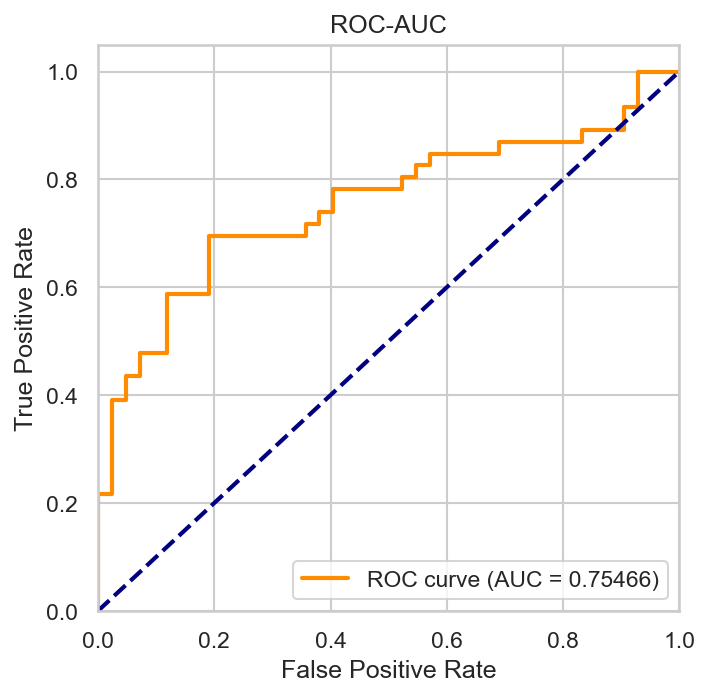

FPR        TPR      THRESHOLD   TPR - FPR
0.0000     0.0000     1.9670     0.0000
0.0000     0.0217     0.9670     0.0217
0.0000     0.2174     0.8608     0.2174
0.0238     0.2174     0.8579     0.1936
0.0238     0.3913     0.7286     0.3675
0.0476     0.3913     0.7204     0.3437
0.0476     0.4348     0.6434     0.3872
0.0714     0.4348     0.6265     0.3634
0.0714     0.4783     0.6017     0.4068
0.1190     0.4783     0.5863     0.3592
0.1190     0.5870     0.5220     0.4679
0.1905     0.5870     0.4500     0.3965
0.1905     0.6957     0.4013     0.5052
0.3571     0.6957     0.3523     0.3385
0.3571     0.7174     0.3519     0.3602
0.3810     0.7174     0.3479     0.3364
0.3810     0.7391     0.3400     0.3582
0.4048     0.7391     0.3393     0.3344
0.4048     0.7826     0.3246     0.3778
0.5238     0.7826     0.2721     0.2588
0.5238     0.8043     0.2652     0.2805
0.5476     0.8043     0.2649     0.2567
0.5476     0.8261     0.2466     0.2785
0.5714     0.8261     0.2446     0.254

In [174]:
test_features = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

#Logistic Regression 
#model = pickle.load(open(f'../models/{class_name}/logistic_regression_model.pkl', 'rb'))
#y_prob = model.predict_proba(test_features)[:, 1]

# LGBM
#model = pickle.load(open(f'../models/{class_name}/lgbm_model.pkl', 'rb'))
#y_prob = model.predict_proba(X = test_features)[:, 1]

# Keras MLP
model = keras.models.load_model(f'../models/{class_name}/keras_model')
y_prob = model.predict(test_features)

fpr, tpr, tresholds = roc_auc_plot(y_test, y_prob, print_table = True)